# Пример использования PaperResearchAgent

Этот ноутбук демонстрирует работу с агентом для поиска и извлечения структурированной информации об AutoML фреймворках из научных статей.

## Новые возможности агента:

- ✅ **Итеративное улучшение извлечения** — автоматическая верификация качества и повтор до 3 раз
- ✅ **Обогащение через Tavily** — автоматический поиск дополнительной информации в интернете
- ✅ **Дедупликация фреймворков** — автоматическое обнаружение и объединение дубликатов
- ✅ **Расширенное логирование** — детальная информация о процессе извлечения

**Для работы обогащения через Tavily**: установите переменную окружения `TAVILY_API_KEY`


## 1. Импорт необходимых библиотек


In [ ]:
# Автоперезагрузка модулей при изменении кода
%load_ext autoreload
%autoreload 2

from mas_automl.agents import PaperResearchAgent
import arxiv
import asyncio


## 2. Инициализация агента

Создаём экземпляр `PaperResearchAgent`, который будет искать статьи и извлекать структурированную информацию об AutoML фреймворках.


In [ ]:
# Создаём агента в обычном режиме
agent = PaperResearchAgent()
test_agent = PaperResearchAgent(test_mode=True)

## 3. Поиск и извлечение информации о фреймворках

Агент использует LangGraph для оркестрации процесса:
1. **Поиск статей в arXiv** — поиск релевантных статей по запросу
2. **Анализ релевантности** — фильтрация статей через LLM
3. **Извлечение информации** — извлечение структурированной информации о фреймворках с помощью LLM
4. **Верификация качества** — проверка качества извлечения и итеративное улучшение (до 3 итераций)
5. **Объединение** — объединение информации о фреймворках из разных статей
6. **Дедупликация** — удаление дубликатов по slug и похожим названиям
7. **Обогащение** — дополнение данных через Tavily API (примеры кода, репозитории, бенчмарки)

### Новые возможности:

- **Итеративное улучшение извлечения**: агент автоматически проверяет качество извлечения и может повторить процесс до 3 раз с улучшенными инструкциями
- **Верификация качества**: оценка качества извлечения (0-100) с конкретными рекомендациями
- **Обогащение через Tavily**: автоматический поиск дополнительной информации в интернете (репозитории, примеры кода, бенчмарки)
- **Дедупликация**: автоматическое обнаружение и объединение дубликатов фреймворков

Для каждого найденного фреймворка извлекается следующая информация:
- **Название и slug** — название фреймворка и автоматически генерируемый URL-friendly идентификатор
- **Описание** — назначение и основные возможности фреймворка
- **Сильные стороны** — в чем фреймворк преуспевает
- **Слабые стороны** — ограничения и недостатки
- **Категории** — типы задач и данных (tabular, time-series, multimodal, NAS, HPO, pipeline-automation, LLM-based AutoML и т.п.)
- **Архитектура** — архитектурные компоненты (searcher, evaluator, meta-learner, feature-engineering, pipeline-generator и т.п.)
- **Результаты в бенчмарках** — места в рейтингах, метрики, типы датасетов
- **Примеры кода** — фрагменты API, примеры использования из статьи
- **Ссылки на статьи** — URL статей, где упоминается фреймворк

### 3.1. Формирование запросов для поиска статей о фреймворках

Для поиска статей о фреймворках, бенчмарках и тестировании AutoML систем (например, как "AMLB: an AutoML Benchmark"), включите в запрос соответствующие ключевые слова:
- `framework`, `frameworks`
- `benchmark`, `benchmarking`
- `evaluation`, `evaluating`
- `tool`, `tools`
- `system`, `systems`
- `library`, `libraries`
- `platform`, `platforms`


### Доступные варианты сортировки:

- `arxiv.SortCriterion.Relevance` (по умолчанию) - сортировка по релевантности запросу
- `arxiv.SortCriterion.SubmittedDate` - сортировка по дате подачи статьи (новые сначала)
- `arxiv.SortCriterion.LastUpdatedDate` - сортировка по дате последнего обновления

### Примеры использования фильтра по дате:

- `days_back=30` - только статьи за последний месяц
- `days_back=90` - только статьи за последние 3 месяца  
- `days_back=365` - только статьи за последний год


In [ ]:
# Пример: поиск новых статей об AutoML фреймворках за последние 2 года
# Сортировка по релевантности и фильтр: только статьи за последние 2 года
query_new = "AutoML framework benchmark library evaluation"
result_new = await agent.handle(
    query_new,
    sort_by=arxiv.SortCriterion.Relevance,
    days_back=365,  # Только статьи за последний год
    max_results=10,
)

print(f"Запрос: {result_new.get('query', '')}")
print(f"Найдено статей: {len(result_new.get('papers', []))}")
print(f"Отфильтровано статей: {len(result_new.get('filtered_papers', []))}")

# Показываем информацию о верификации
extraction_iteration = result_new.get('extraction_iteration', 0)
verification_score = result_new.get('verification_score')
if verification_score is not None:
    print(f"\n📊 Верификация качества:")
    print(f"   Итераций извлечения: {extraction_iteration}")
    print(f"   Оценка качества: {verification_score}/100")
    if result_new.get('verification_feedback'):
        print(f"   Фидбек: {result_new.get('verification_feedback')[:200]}...")

print(f"\nНайдено уникальных фреймворков: {len(result_new.get('frameworks', []))}")
print("\nНайденные статьи:")
for i, paper in enumerate(result_new.get('papers', []), 1):
    print(f"\n{i}. {paper.get('title', 'N/A')}")
    print(f"   Дата публикации: {paper.get('published_date', 'N/A')}")
    print(f"   URL: {paper.get('url', 'N/A')}")


Запрос: AutoML framework benchmark library evaluation
Найдено статей: 8
Отфильтровано статей: 3

📊 Верификация качества:
   Итераций извлечения: 3
   Оценка качества: 65/100
   Фидбек: Так как это последняя итерация, повторное извлечение не требуется. Однако, если бы оно было возможно, следовало бы попытаться найти более полные описания фреймворков и проверить наличие примеров кода ...

Найдено уникальных фреймворков: 30

Найденные статьи:

1. SECQUE: A Benchmark for Evaluating Real-World Financial Analysis Capabilities
   Дата публикации: 2025-04-06 19:59:41+00:00
   URL: http://arxiv.org/abs/2504.04596v1

2. AutoML Benchmark with shorter time constraints and early stopping
   Дата публикации: 2025-04-01 22:22:15+00:00
   URL: http://arxiv.org/abs/2504.01222v3

3. confopt: A Library for Implementation and Evaluation of Gradient-based One-Shot NAS Methods
   Дата публикации: 2025-07-22 12:44:28+00:00
   URL: http://arxiv.org/abs/2507.16533v1

4. Toward Autonomous and Efficient Cybersec

In [4]:
# Показываем структурированную информацию о найденных фреймворках
frameworks = result_new.get('frameworks', [])
print(f"\n\n=== СТРУКТУРИРОВАННАЯ ИНФОРМАЦИЯ О ФРЕЙМВОРКАХ ===\n")
print(f"Всего найдено уникальных фреймворков: {len(frameworks)}\n")

for i, fw in enumerate(frameworks, 1):
    print(f"{'='*80}")
    name = fw.get('name', 'N/A')
    slug = fw.get('slug', '')
    print(f"{i}. {name}" + (f" (slug: {slug})" if slug else ""))
    print(f"{'='*80}")
    
    # Описание
    description = fw.get('description', '')
    if description:
        print(f"\n📝 Описание:")
        print(f"   {description}")
    
    # Сильные стороны
    strengths = fw.get('strengths', [])
    if strengths:
        print(f"\n💪 Сильные стороны:")
        for strength in strengths:
            print(f"   • {strength}")
    
    # Слабые стороны
    weaknesses = fw.get('weaknesses', [])
    if weaknesses:
        print(f"\n⚠️  Слабые стороны:")
        for weakness in weaknesses:
            print(f"   • {weakness}")
    
    # Категории
    categories = fw.get('categories', [])
    if categories:
        print(f"\n📂 Категории:")
        print(f"   {', '.join(categories)}")
    
    # Архитектура
    architecture = fw.get('architecture', [])
    if architecture:
        print(f"\n🏗️  Архитектурные компоненты:")
        for component in architecture:
            print(f"   • {component}")
    
    # Результаты в бенчмарках
    benchmarks = fw.get('benchmarks', [])
    if benchmarks:
        print(f"\n🏆 Результаты в бенчмарках:")
        for benchmark in benchmarks:
            print(f"   • {benchmark}")
    
    # Код из статьи
    code = fw.get('code', [])
    if code:
        print(f"\n💻 Примеры кода:")
        for code_snippet in code[:3]:  # Показываем первые 3 примера
            # Очищаем код от markdown форматирования (убираем ``` в начале и конце)
            cleaned_code = code_snippet.strip()
            
            # Убираем открывающие ``` и указание языка (например, ```python или ```json)
            if cleaned_code.startswith('```'):
                # Находим конец первой строки с ``` (может быть ```python или просто ```)
                first_newline = cleaned_code.find('\n')
                if first_newline != -1:
                    # Пропускаем всю первую строку (```python или ```)
                    cleaned_code = cleaned_code[first_newline + 1:].lstrip()
                else:
                    # Если нет переноса строки, просто убираем ``` и все что после до конца
                    cleaned_code = cleaned_code[3:].strip()
                    # Если после ``` было указание языка, убираем его
                    if cleaned_code.startswith(('python', 'json', 'javascript', 'java', 'cpp', 'c', 'go', 'rust')):
                        space_idx = cleaned_code.find(' ')
                        if space_idx != -1:
                            cleaned_code = cleaned_code[space_idx + 1:]
                        else:
                            cleaned_code = ''
            
            # Убираем закрывающие ```
            cleaned_code = cleaned_code.rstrip()
            if cleaned_code.endswith('```'):
                cleaned_code = cleaned_code[:-3].rstrip()
            
            # Выводим код с отступом, без дополнительных кавычек
            code_preview = cleaned_code[:300] + ('...' if len(cleaned_code) > 300 else '')
            for line in code_preview.split('\n'):
                print(f"   {line}")
    
    # Репозитории
    repos = fw.get('repository_urls', [])
    if repos:
        print(f"\n🔗 Репозитории:")
        for repo in repos:
            print(f"   • {repo}")
    
    # Ссылки на статьи
    paper_urls = fw.get('paper_urls', [])
    paper_url = fw.get('paper_url', '')
    if paper_urls:
        print(f"\n📄 Статьи:")
        for url in paper_urls:
            print(f"   • {url}")
    elif paper_url:
        print(f"\n📄 Статья:")
        print(f"   • {paper_url}")
    
    print("\n")




=== СТРУКТУРИРОВАННАЯ ИНФОРМАЦИЯ О ФРЕЙМВОРКАХ ===

Всего найдено уникальных фреймворков: 30

1. AutoGluon (slug: autogluon)

📝 Описание:
   AutoGluon-tabular is a robust and accurate AutoML framework for structured data. It has demonstrated state-of-the-art performance in tabular tasks. Multiple configurations varying in training and inference time are evaluated: AutoGluon(B), AutoGluon(HQ), AutoGluon(HQIL), and AutoGluon(FIFTIL).

💪 Сильные стороны:
   • Achieves the best rank for all time constraints due to its use of a meta-learned portfolio.
   • Consistently exhibits the lowest error rates across different time constraints.
   • Maintains relatively stable performance with fewer failures across different time constraints.
   • Can save time while reducing regret, but sometimes also sacrifice time for performance (when using early stopping).
   • AutoGluon(HQIL) shows that larger datasets might benefit more from early stopping by avoiding over-refinement.

📂 Категории:
   tabula

## 4. Анализ процесса верификации и итеративного улучшения

Агент автоматически проверяет качество извлечения и может повторить процесс до 3 раз для улучшения результатов.


In [5]:
# Анализируем процесс верификации
print("=== АНАЛИЗ ПРОЦЕССА ВЕРИФИКАЦИИ ===\n")

extraction_iteration = result_new.get('extraction_iteration', 0)
verification_score = result_new.get('verification_score')
verification_feedback = result_new.get('verification_feedback')

print(f"Количество итераций извлечения: {extraction_iteration}")
if verification_score is not None:
    print(f"Оценка качества извлечения: {verification_score}/100")
    if verification_score >= 80:
        print("✅ Отличное качество извлечения")
    elif verification_score >= 60:
        print("✅ Хорошее качество извлечения")
    elif verification_score >= 40:
        print("⚠️  Среднее качество извлечения")
    else:
        print("❌ Низкое качество извлечения")

if verification_feedback:
    print(f"\n📝 Рекомендации для улучшения:")
    print(f"   {verification_feedback}")

# Показываем статистику по статьям
paper_frameworks = result_new.get('paper_frameworks', [])
print(f"\n📊 Статистика по извлечению:")
print(f"   Обработано статей: {len(paper_frameworks)}")
total_frameworks = sum(len(p.get('frameworks', [])) for p in paper_frameworks)
print(f"   Всего найдено фреймворков (до объединения): {total_frameworks}")
print(f"   Уникальных фреймворков (после дедупликации): {len(result_new.get('frameworks', []))}")


=== АНАЛИЗ ПРОЦЕССА ВЕРИФИКАЦИИ ===

Количество итераций извлечения: 3
Оценка качества извлечения: 65/100
✅ Хорошее качество извлечения

📝 Рекомендации для улучшения:
   Так как это последняя итерация, повторное извлечение не требуется. Однако, если бы оно было возможно, следовало бы попытаться найти более полные описания фреймворков и проверить наличие примеров кода в статьях или связанных репозиториях.

📊 Статистика по извлечению:
   Обработано статей: 3
   Всего найдено фреймворков (до объединения): 31
   Уникальных фреймворков (после дедупликации): 30


## 5. Обогащение данных через Tavily

Агент автоматически обогащает данные о фреймворках информацией из интернета:
- Поиск репозиториев на GitHub/GitLab
- Поиск примеров кода и документации
- Поиск результатов бенчмарков

**Примечание**: Для работы обогащения необходим API ключ Tavily. Установите переменную окружения `TAVILY_API_KEY`.


In [6]:
# Анализируем, что именно добавил Tavily
# Сравниваем данные из статей (до обогащения) с финальными данными (после обогащения)

print("=== АНАЛИЗ ОБОГАЩЕННЫХ ДАННЫХ ЧЕРЕЗ TAVILY ===\n")

# Собираем данные из статей (до обогащения)
frameworks_before_enrichment = {}
paper_frameworks = result_new.get('paper_frameworks', [])
for paper_data in paper_frameworks:
    for fw in paper_data.get('frameworks', []):
        fw_dict = fw if isinstance(fw, dict) else fw.model_dump() if hasattr(fw, 'model_dump') else {}
        name = fw_dict.get('name', '')
        if name:
            if name not in frameworks_before_enrichment:
                frameworks_before_enrichment[name] = {
                    'repository_urls': set(fw_dict.get('repository_urls', [])),
                    'code': set(fw_dict.get('code', [])),
                    'benchmarks': set(fw_dict.get('benchmarks', [])),
                }
            else:
                frameworks_before_enrichment[name]['repository_urls'].update(fw_dict.get('repository_urls', []))
                frameworks_before_enrichment[name]['code'].update(fw_dict.get('code', []))
                frameworks_before_enrichment[name]['benchmarks'].update(fw_dict.get('benchmarks', []))

# Сравниваем с финальными данными (после обогащения)
frameworks_after = result_new.get('frameworks', [])
enriched_count = 0
added_by_tavily = 0

for fw in frameworks_after:
    name = fw.get('name', 'N/A')
    repos_after = set(fw.get('repository_urls', []))
    code_after = set(fw.get('code', []))
    benchmarks_after = set(fw.get('benchmarks', []))
    
    # Получаем данные до обогащения
    repos_before = frameworks_before_enrichment.get(name, {}).get('repository_urls', set())
    code_before = frameworks_before_enrichment.get(name, {}).get('code', set())
    benchmarks_before = frameworks_before_enrichment.get(name, {}).get('benchmarks', set())
    
    # Вычисляем разницу (что добавил Tavily)
    repos_added = repos_after - repos_before
    code_added = code_after - code_before
    benchmarks_added = benchmarks_after - benchmarks_before
    
    # Проверяем, было ли что-то добавлено
    if repos_added or code_added or benchmarks_added:
        enriched_count += 1
        added_by_tavily += len(repos_added) + len(code_added) + len(benchmarks_added)
        
        print(f"📦 {name}")
        print(f"   До обогащения: репозиториев={len(repos_before)}, кода={len(code_before)}, бенчмарков={len(benchmarks_before)}")
        print(f"   После обогащения: репозиториев={len(repos_after)}, кода={len(code_after)}, бенчмарков={len(benchmarks_after)}")
        
        if repos_added:
            print(f"   ✅ Добавлено репозиториев через Tavily: {len(repos_added)}")
            for repo in list(repos_added)[:3]:  # Показываем первые 3
                print(f"      • {repo}")
        
        if code_added:
            print(f"   ✅ Добавлено примеров кода через Tavily: {len(code_added)}")
            for code_snippet in list(code_added)[:1]:  # Показываем первый пример
                preview = code_snippet[:150] + ('...' if len(code_snippet) > 150 else '')
                print(f"      • {preview}")
        
        if benchmarks_added:
            print(f"   ✅ Добавлено бенчмарков через Tavily: {len(benchmarks_added)}")
            for bench in list(benchmarks_added)[:1]:  # Показываем первый
                preview = bench[:150] + ('...' if len(bench) > 150 else '')
                print(f"      • {preview}")
        
        print()

# Диагностика: определяем причину, почему Tavily не добавил данных
if enriched_count == 0:
    print("⚠️  Tavily не добавил новых данных.\n")
    
    # Проверяем причины
    import os
    tavily_api_key = os.getenv("TAVILY_API_KEY")
    
    print("🔍 Диагностика:")
    
    # Причина 1: API ключ не установлен
    if not tavily_api_key:
        print("   ❌ API ключ Tavily НЕ установлен (TAVILY_API_KEY)")
        print("      Решение: установите переменную окружения TAVILY_API_KEY")
    else:
        print("   ✅ API ключ Tavily установлен")
    
    # Причина 2: Проверяем, были ли данные в статьях
    total_before = sum(
        len(frameworks_before_enrichment.get(name, {}).get('repository_urls', set())) +
        len(frameworks_before_enrichment.get(name, {}).get('code', set())) +
        len(frameworks_before_enrichment.get(name, {}).get('benchmarks', set()))
        for name in frameworks_before_enrichment.keys()
    )
    
    if total_before > 0:
        print(f"   ✅ В статьях уже были данные: {total_before} элементов")
        print("      Возможно, Tavily не нашел дополнительной информации")
    else:
        print("   ⚠️  В статьях не было данных (репозитории, код, бенчмарки)")
        print("      Tavily должен был добавить данные, но не добавил")
    
    # Причина 3: Проверяем, был ли enricher активен и что он нашел
    print("\n   💡 Для детальной диагностики проверьте логи агента:")
    print("      - 'Начало обогащения данных для X фреймворков' - enricher запущен")
    print("      - 'Tavily нашел X результатов для {name}' - поиск успешен")
    print("      - 'LLM извлек из результатов Tavily: ...' - данные извлечены")
    print("      - 'Данные не добавлены: все элементы уже присутствуют' - дубликаты")
    print("\n   ⚠️  Если Tavily нашел результаты, но данные не добавились:")
    print("      - Возможно, все найденные данные уже были в статьях (дубликаты)")
    print("      - Или LLM не смог извлечь структурированные данные из результатов")
    
else:
    print(f"✅ Всего фреймворков с данными от Tavily: {enriched_count} из {len(frameworks_after)}")
    print(f"✅ Всего элементов добавлено через Tavily: {added_by_tavily}")


=== АНАЛИЗ ОБОГАЩЕННЫХ ДАННЫХ ЧЕРЕЗ TAVILY ===

📦 DARTS
   До обогащения: репозиториев=0, кода=0, бенчмарков=2
   После обогащения: репозиториев=3, кода=0, бенчмарков=2
   ✅ Добавлено репозиториев через Tavily: 3
      • https://github.com/milosz-l/DartML
      • https://github.com/Meituan-AutoML/DARTS-
      • https://github.com/automl/RobustDARTS

✅ Всего фреймворков с данными от Tavily: 1 из 30
✅ Всего элементов добавлено через Tavily: 3


## 6. Дедупликация фреймворков

Агент автоматически обнаруживает и объединяет дубликаты фреймворков по slug и похожим названиям.


In [8]:
# Анализируем дедупликацию
print("=== АНАЛИЗ ДЕДУПЛИКАЦИИ ===\n")

frameworks = result_new.get('frameworks', [])
print(f"Уникальных фреймворков после дедупликации: {len(frameworks)}")

# Показываем фреймворки с их slug
print("\nФреймворки с slug (для проверки дедупликации):")
for i, fw in enumerate(frameworks[:10], 1):  # Показываем первые 10
    name = fw.get('name', 'N/A')
    slug = fw.get('slug', '')
    paper_urls = fw.get('paper_urls', [])
    print(f"{i}. {name} (slug: {slug})")
    if len(paper_urls) > 1:
        print(f"   📄 Объединено из {len(paper_urls)} статей")


=== АНАЛИЗ ДЕДУПЛИКАЦИИ ===

Уникальных фреймворков после дедупликации: 30

Фреймворки с slug (для проверки дедупликации):
1. AutoGluon (slug: autogluon)
2. autosklearn (slug: autosklearn)
3. autosklearn2 (slug: autosklearn2)
4. flaml (slug: flaml)
5. GAMA (slug: gama)
6. H2OAutoML (slug: h2oautoml)
7. lightAutoML (slug: lightautoml)
8. MLJAR(B) (slug: mljar-b)
9. TPOT (slug: tpot)
10. FEDOT (slug: fedot)


## 7. Пример с тестовым режимом

В тестовом режиме агент работает быстрее, но с ограничениями:
- Ищет меньше статей (2 вместо 6)
- Извлекает информацию только из абстрактов, а не из полного PDF
- Не выполняет верификацию и обогащение (если не указан LLM)


In [6]:
# Пример с тестовым режимом (быстрый тест)
print("=== ТЕСТОВЫЙ РЕЖИМ ===\n")

test_query = "AutoML tabular"
test_result = await test_agent.handle(
    test_query,
    max_results=20,
)

print(f"Запрос: {test_result.get('query', '')}")
print(f"Найдено статей: {len(test_result.get('papers', []))}")
print(f"Найдено фреймворков: {len(test_result.get('frameworks', []))}")

# В тестовом режиме верификация может быть отключена
if test_result.get('verification_score') is not None:
    print(f"Оценка качества: {test_result.get('verification_score')}/100")
else:
    print("Верификация: отключена (тестовый режим)")


=== ТЕСТОВЫЙ РЕЖИМ ===



Запрос: AutoML tabular
Найдено статей: 20
Найдено фреймворков: 0
Верификация: отключена (тестовый режим)


In [7]:
# Также можно посмотреть информацию о фреймворках по статьям
print("=== ИНФОРМАЦИЯ О ФРЕЙМВОРКАХ ПО СТАТЬЯМ ===\n")
paper_frameworks = result_new.get('paper_frameworks', [])
for i, paper_data in enumerate(paper_frameworks, 1):
    print(f"{i}. {paper_data.get('title', 'N/A')}")
    frameworks = paper_data.get('frameworks', [])
    if frameworks:
        print(f"   Найдено фреймворков: {len(frameworks)}")
        for fw in frameworks:
            fw_name = fw.get('name', 'N/A') if isinstance(fw, dict) else getattr(fw, 'name', 'N/A')
            print(f"   • {fw_name}")
    else:
        print("   Фреймворки не найдены")
    print()


=== ИНФОРМАЦИЯ О ФРЕЙМВОРКАХ ПО СТАТЬЯМ ===

1. AutoML-Agent: A Multi-Agent LLM Framework for Full-Pipeline AutoML
   Найдено фреймворков: 13
   • AutoML-Agent
   • AutoML-GPT
   • Prompt2Model
   • HuggingGPT
   • CAAFE
   • MLCopilot
   • AgentHPO
   • Data Interpreter
   • DS-Agent
   • SELA
   • Agent K
   • AutoMMLab
   • AutoGluon

2. AutoGluon-Multimodal (AutoMM): Supercharging Multimodal AutoML with Foundation Models
   Найдено фреймворков: 10
   • AutoGluon-Multimodal (AutoMM)
   • AutoKeras
   • Auto-Sklearn
   • TPOT
   • H2O AutoML
   • FLAML
   • LightAutoML
   • Quick-Tune
   • TabPFN
   • OptFormer

3. Confidence Interval Estimation of Predictive Performance in the Context of AutoML
   Найдено фреймворков: 3
   • JADBio
   • BBC
   • BBC-F

4. Towards Autonomous Cybersecurity: An Intelligent AutoML Framework for Autonomous Intrusion Detection
   Найдено фреймворков: 4
   • AutoML-based autonomous IDS framework
   • AutoDP
   • AutoFE
   • Optimized Confidence-based Stack

## 4. Анализ статей по фреймворкам за последние 10 лет

Анализируем количество статей по фреймворкам за последние 10 лет в разрезе каждого года и подсчитываем сколько из них содержат ссылки на GitHub.

**Примечание:** По умолчанию агент обрабатывает 50 статей (вместо стандартных 6) для более полного анализа. Это значение можно увеличить до 100-200 статей, но учтите, что обработка каждой статьи требует времени (особенно извлечение информации из PDF), поэтому анализ может занять значительное время.


In [3]:
# Анализ статей по фреймворкам за последние 10 лет
from datetime import datetime, timedelta
from collections import defaultdict
import re

async def analyze_frameworks_by_year(years_back=10):
    """
    Анализирует статьи по фреймворкам за последние N лет.
    Группирует по годам и подсчитывает статьи с GitHub ссылками.
    
    Использует один запрос за весь период для получения большего количества статей,
    затем группирует результаты по годам.
    """
    # Создаём агента
    agent = PaperResearchAgent()
    
    # Словари для хранения статистики
    papers_by_year = defaultdict(list)
    papers_with_github_by_year = defaultdict(int)
    total_papers_by_year = defaultdict(int)
    
    # Запрос для поиска статей о фреймворках
    query = "AutoML framework benchmark library evaluation tool system"
    
    current_year = datetime.now().year
    start_year = current_year - years_back + 1
    days_back = years_back * 365
    
    # Увеличиваем количество статей для более полного анализа
    # Для анализа за 10 лет используем 50-100 статей вместо дефолтных 6
    max_results = 500
    
    print(f"Анализ статей за период: {start_year} - {current_year}")
    print(f"Выполняем поиск статей за последние {days_back} дней...")
    print(f"Максимальное количество статей для анализа: {max_results}")
    print("=" * 80)
    
    try:
        # Делаем один запрос за весь период
        # Используем SubmittedDate для сортировки по дате
        result = await agent.handle(
            query,
            sort_by=arxiv.SortCriterion.Relevance,
            days_back=days_back,
            max_results=max_results  # Увеличиваем количество статей для анализа
        )
        
        papers = result.get('papers', [])
        paper_frameworks = result.get('paper_frameworks', [])
        
        print(f"\nВсего найдено статей: {len(papers)}")
        print(f"Всего обработано статей с фреймворками: {len(paper_frameworks)}")
        
        # Создаём словарь для быстрого поиска фреймворков по названию статьи
        frameworks_by_paper_title = {}
        for paper_fw in paper_frameworks:
            title = paper_fw.get('title', '')
            frameworks_by_paper_title[title] = paper_fw.get('frameworks', [])
        
        # Группируем статьи по годам и проверяем наличие GitHub ссылок
        for paper in papers:
            published_date = paper.get('published_date', '')
            if not published_date:
                continue
            
            # Парсим дату публикации
            paper_date = None
            try:
                # Убираем timezone для парсинга
                date_str = published_date.split('+')[0].split('.')[0].strip()
                paper_date = datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S')
            except:
                try:
                    # Пробуем другой формат
                    paper_date = datetime.fromisoformat(published_date.replace('Z', '+00:00'))
                except:
                    continue
            
            if paper_date is None:
                continue
            
            year = paper_date.year
            
            # Проверяем, попадает ли год в нужный диапазон
            if start_year <= year <= current_year:
                papers_by_year[year].append(paper)
                total_papers_by_year[year] = total_papers_by_year.get(year, 0) + 1
                
                # Проверяем наличие GitHub ссылок в фреймворках этой статьи
                paper_title = paper.get('title', '')
                frameworks = frameworks_by_paper_title.get(paper_title, [])
                
                has_github = False
                for fw in frameworks:
                    repos = fw.get('repository_urls', [])
                    # Проверяем наличие GitHub ссылок
                    for repo in repos:
                        if repo and ('github.com' in repo.lower() or 'github.io' in repo.lower()):
                            has_github = True
                            break
                    if has_github:
                        break
                
                if has_github:
                    papers_with_github_by_year[year] = papers_with_github_by_year.get(year, 0) + 1
        
        # Выводим промежуточную статистику
        print("\nСтатистика по годам:")
        for year in sorted(papers_by_year.keys()):
            total = total_papers_by_year.get(year, 0)
            github = papers_with_github_by_year.get(year, 0)
            print(f"  {year}: {total} статей, {github} с GitHub")
        
    except Exception as e:
        print(f"Ошибка при выполнении анализа: {e}")
        import traceback
        traceback.print_exc()
    
    return {
        'papers_by_year': dict(papers_by_year),
        'papers_with_github_by_year': dict(papers_with_github_by_year),
        'total_papers_by_year': dict(total_papers_by_year)
    }

# Запускаем анализ
analysis_result = await analyze_frameworks_by_year(years_back=10)


Анализ статей за период: 2016 - 2025
Выполняем поиск статей за последние 3650 дней...
Максимальное количество статей для анализа: 500


Multiple definitions in dictionary at byte 0x2995d for key /Rotate
Multiple definitions in dictionary at byte 0x2995d for key /Rotate
Ошибка при поиске в Tavily: This request exceeds your plan's set usage limit. Please upgrade your plan or contact support@tavily.com
Не удалось выполнить поиск в Tavily после 3 попыток. Последняя ошибка: This request exceeds your plan's set usage limit. Please upgrade your plan or contact support@tavily.com
Ошибка при поиске в Tavily: This request exceeds your plan's set usage limit. Please upgrade your plan or contact support@tavily.com
Не удалось выполнить поиск в Tavily после 3 попыток. Последняя ошибка: This request exceeds your plan's set usage limit. Please upgrade your plan or contact support@tavily.com
Ошибка при поиске в Tavily: This request exceeds your plan's set usage limit. Please upgrade your plan or contact support@tavily.com
Не удалось выполнить поиск в Tavily после 3 попыток. Последняя ошибка: This request exceeds your plan's set usage l


Всего найдено статей: 500
Всего обработано статей с фреймворками: 161

Статистика по годам:
  2016: 10 статей, 0 с GitHub
  2017: 7 статей, 0 с GitHub
  2018: 21 статей, 2 с GitHub
  2019: 25 статей, 9 с GitHub
  2020: 41 статей, 10 с GitHub
  2021: 55 статей, 12 с GitHub
  2022: 51 статей, 16 с GitHub
  2023: 70 статей, 15 с GitHub
  2024: 88 статей, 20 с GitHub
  2025: 132 статей, 18 с GitHub


In [ ]:
Всего найдено статей: 500
Всего обработано статей с фреймворками: 161

Статистика по годам:
  2016: 10 статей, 0 с GitHub
  2017: 7 статей, 0 с GitHub
  2018: 21 статей, 2 с GitHub
  2019: 25 статей, 9 с GitHub
  2020: 41 статей, 10 с GitHub
  2021: 55 статей, 12 с GitHub
  2022: 51 статей, 16 с GitHub
  2023: 70 статей, 15 с GitHub
  2024: 88 статей, 20 с GitHub
  2025: 132 статей, 18 с GitHub

In [5]:
# Выводим результаты анализа
print("\n" + "=" * 80)
print("РЕЗУЛЬТАТЫ АНАЛИЗА СТАТЕЙ ПО ФРЕЙМВОРКАМ ЗА ПОСЛЕДНИЕ 10 ЛЕТ")
print("=" * 80)
print()

total_papers_by_year = analysis_result['total_papers_by_year']
papers_with_github_by_year = analysis_result['papers_with_github_by_year']

# Сортируем годы
years = sorted(total_papers_by_year.keys())

# Выводим таблицу
print(f"{'Год':<10} {'Всего статей':<15} {'С GitHub':<15} {'% с GitHub':<15}")
print("-" * 60)

total_all = 0
total_github = 0

for year in years:
    total = total_papers_by_year.get(year, 0)
    github = papers_with_github_by_year.get(year, 0)
    percentage = (github / total * 100) if total > 0 else 0
    
    print(f"{year:<10} {total:<15} {github:<15} {percentage:.1f}%")
    
    total_all += total
    total_github += github

print("-" * 60)
overall_percentage = (total_github / total_all * 100) if total_all > 0 else 0
print(f"{'ИТОГО':<10} {total_all:<15} {total_github:<15} {overall_percentage:.1f}%")
print()

# Дополнительная статистика
print("Дополнительная информация:")
print(f"  • Всего проанализировано статей: {total_all}")
print(f"  • Статей с GitHub ссылками: {total_github}")
print(f"  • Процент статей с GitHub: {overall_percentage:.1f}%")
print(f"  • Среднее количество статей в год: {total_all / len(years):.1f}")



РЕЗУЛЬТАТЫ АНАЛИЗА СТАТЕЙ ПО ФРЕЙМВОРКАМ ЗА ПОСЛЕДНИЕ 10 ЛЕТ

Год        Всего статей    С GitHub        % с GitHub     
------------------------------------------------------------
2016       10              0               0.0%
2017       7               0               0.0%
2018       21              2               9.5%
2019       25              9               36.0%
2020       41              10              24.4%
2021       55              12              21.8%
2022       51              16              31.4%
2023       70              15              21.4%
2024       88              20              22.7%
2025       132             18              13.6%
------------------------------------------------------------
ИТОГО      500             102             20.4%

Дополнительная информация:
  • Всего проанализировано статей: 500
  • Статей с GitHub ссылками: 102
  • Процент статей с GitHub: 20.4%
  • Среднее количество статей в год: 50.0


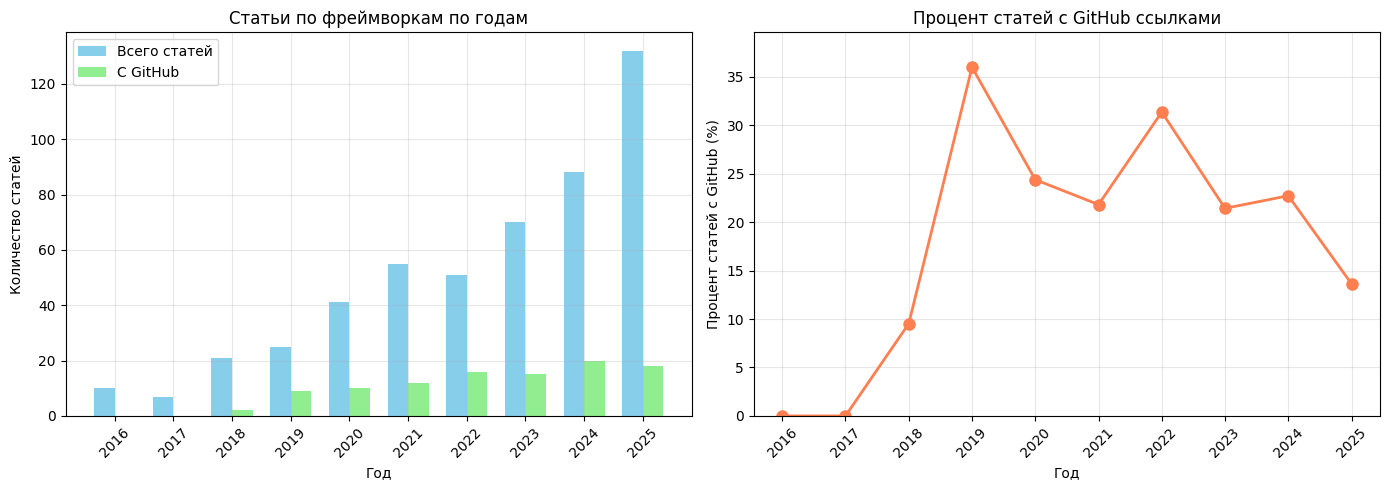

In [6]:
# Визуализация результатов (опционально)
try:
    import matplotlib.pyplot as plt
    import numpy as np
    
    total_papers_by_year = analysis_result['total_papers_by_year']
    papers_with_github_by_year = analysis_result['papers_with_github_by_year']
    
    years = sorted(total_papers_by_year.keys())
    if years:
        totals = [total_papers_by_year.get(year, 0) for year in years]
        githubs = [papers_with_github_by_year.get(year, 0) for year in years]
        percentages = [(githubs[i] / totals[i] * 100) if totals[i] > 0 else 0 for i in range(len(years))]
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
        
        # График 1: Количество статей по годам
        x = np.arange(len(years))
        width = 0.35
        ax1.bar(x - width/2, totals, width, label='Всего статей', color='skyblue')
        ax1.bar(x + width/2, githubs, width, label='С GitHub', color='lightgreen')
        ax1.set_xlabel('Год')
        ax1.set_ylabel('Количество статей')
        ax1.set_title('Статьи по фреймворкам по годам')
        ax1.set_xticks(x)
        ax1.set_xticklabels(years, rotation=45)
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # График 2: Процент статей с GitHub
        ax2.plot(years, percentages, marker='o', linewidth=2, markersize=8, color='coral')
        ax2.set_xlabel('Год')
        ax2.set_ylabel('Процент статей с GitHub (%)')
        ax2.set_title('Процент статей с GitHub ссылками')
        ax2.set_xticks(years)
        ax2.set_xticklabels(years, rotation=45)
        ax2.grid(True, alpha=0.3)
        ax2.set_ylim([0, max(percentages) * 1.1 if max(percentages) > 0 else 100])
        
        plt.tight_layout()
        plt.show()
    else:
        print("Нет данных для визуализации")
except ImportError:
    print("Matplotlib не установлен, пропускаем визуализацию")
except Exception as e:
    print(f"Ошибка при создании визуализации: {e}")


## 8. Сбор фреймворков за 10 лет и статистика по первому появлению

Собираем фреймворки за последние 10 лет (минимум 300 статей) и анализируем первое появление каждого фреймворка.


In [1]:
# Сбор фреймворков за 10 лет (минимум 300 статей)
from datetime import datetime, timedelta
from collections import defaultdict
import json

async def collect_frameworks_10_years(min_articles=10):
    """
    Собирает фреймворки за последние 10 лет.
    Ищет минимум min_articles статей.
    """
    agent = PaperResearchAgent()
    
    current_year = datetime.now().year
    start_year = current_year - 3  # 10 лет включая текущий
    days_back = 3 * 365
    
    # Запрос для поиска статей о фреймворках
    query = "AutoML framework benchmark library evaluation tool system"
    
    print(f"🔍 Сбор фреймворков за период: {start_year} - {current_year}")
    print(f"📅 Поиск статей за последние {days_back} дней...")
    print(f"📊 Целевое количество статей: минимум {min_articles}")
    print("=" * 80)
    
    # Увеличиваем max_results для получения большего количества статей
    # arXiv API может вернуть максимум ~2000 результатов за запрос
    max_results = min_articles * 2  # Ищем в 2 раза больше, чтобы после фильтрации получить минимум
    
    all_frameworks = []
    all_papers = []
    all_paper_frameworks = []
    
    try:
        # Делаем запрос за весь период
        result = await agent.handle(
            query,
            sort_by=arxiv.SortCriterion.Relevance,
            days_back=days_back,
            max_results=max_results
        )
        
        papers = result.get('papers', [])
        paper_frameworks = result.get('paper_frameworks', [])
        frameworks = result.get('frameworks', [])
        
        print(f"\n✅ Найдено статей: {len(papers)}")
        print(f"✅ Обработано статей с фреймворками: {len(paper_frameworks)}")
        print(f"✅ Найдено уникальных фреймворков: {len(frameworks)}")
        
        # Проверяем, достаточно ли статей
        if len(papers) < min_articles:
            print(f"\n⚠️  Внимание: найдено только {len(papers)} статей, что меньше целевого минимума {min_articles}")
            print("   Возможно, нужно увеличить max_results или расширить запрос")
        else:
            print(f"\n✅ Цель достигнута: найдено {len(papers)} статей (минимум {min_articles})")
        
        return {
            'papers': papers,
            'paper_frameworks': paper_frameworks,
            'frameworks': frameworks,
            'query': query,
            'start_year': start_year,
            'end_year': current_year,
            'days_back': days_back
        }
        
    except Exception as e:
        print(f"❌ Ошибка при сборе фреймворков: {e}")
        import traceback
        traceback.print_exc()
        return {
            'papers': [],
            'paper_frameworks': [],
            'frameworks': [],
            'query': query,
            'start_year': start_year,
            'end_year': current_year,
            'days_back': days_back,
            'error': str(e)
        }

# Запускаем сбор
collection_result = await collect_frameworks_10_years(min_articles=10)


NameError: name 'PaperResearchAgent' is not defined

In [ ]:
# Анализ первого появления каждого фреймворка
def analyze_first_appearance(collection_result):
    """
    Анализирует первое появление каждого фреймворка по дате публикации статьи.
    """
    papers = collection_result.get('papers', [])
    paper_frameworks = collection_result.get('paper_frameworks', [])
    
    # Создаём словарь: название статьи -> дата публикации
    paper_dates = {}
    for paper in papers:
        title = paper.get('title', '')
        published_date = paper.get('published_date', '')
        if title and published_date:
            # Парсим дату
            try:
                date_str = published_date.split('+')[0].split('.')[0].strip()
                paper_date = datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S')
                paper_dates[title] = paper_date
            except:
                try:
                    paper_date = datetime.fromisoformat(published_date.replace('Z', '+00:00'))
                    paper_dates[title] = paper_date
                except:
                    continue
    
    # Создаём словарь: название фреймворка -> первая дата появления
    framework_first_appearance = {}
    framework_papers = defaultdict(list)  # Для хранения всех статей с фреймворком
    
    for paper_data in paper_frameworks:
        title = paper_data.get('title', '')
        paper_date = paper_dates.get(title)
        
        if not paper_date:
            continue
        
        frameworks = paper_data.get('frameworks', [])
        for fw in frameworks:
            fw_name = fw.get('name', '') if isinstance(fw, dict) else getattr(fw, 'name', '')
            if not fw_name:
                continue
            
            # Обновляем первую дату появления
            if fw_name not in framework_first_appearance:
                framework_first_appearance[fw_name] = paper_date
                framework_papers[fw_name] = [{
                    'title': title,
                    'date': paper_date,
                    'url': paper_data.get('url', '')
                }]
            else:
                # Проверяем, не раньше ли эта дата
                if paper_date < framework_first_appearance[fw_name]:
                    framework_first_appearance[fw_name] = paper_date
                    framework_papers[fw_name] = [{
                        'title': title,
                        'date': paper_date,
                        'url': paper_data.get('url', '')
                    }]
                elif paper_date == framework_first_appearance[fw_name]:
                    # Та же дата - добавляем статью
                    framework_papers[fw_name].append({
                        'title': title,
                        'date': paper_date,
                        'url': paper_data.get('url', '')
                    })
    
    # Сортируем по дате первого появления
    sorted_frameworks = sorted(
        framework_first_appearance.items(),
        key=lambda x: x[1]
    )
    
    return {
        'framework_first_appearance': dict(framework_first_appearance),
        'framework_papers': dict(framework_papers),
        'sorted_frameworks': sorted_frameworks
    }

# Выполняем анализ
first_appearance_stats = analyze_first_appearance(collection_result)


In [ ]:
# Выводим статистику по первому появлению фреймворков
print("=" * 80)
print("СТАТИСТИКА ПО ПЕРВОМУ ПОЯВЛЕНИЮ ФРЕЙМВОРКОВ")
print("=" * 80)
print()

framework_first_appearance = first_appearance_stats['framework_first_appearance']
sorted_frameworks = first_appearance_stats['sorted_frameworks']
framework_papers = first_appearance_stats['framework_papers']

print(f"Всего найдено уникальных фреймворков: {len(framework_first_appearance)}")
print()

# Группируем по годам
frameworks_by_year = defaultdict(list)
for fw_name, first_date in sorted_frameworks:
    year = first_date.year
    frameworks_by_year[year].append((fw_name, first_date))

# Выводим статистику по годам
print("📊 Распределение первого появления фреймворков по годам:")
print("-" * 80)
for year in sorted(frameworks_by_year.keys()):
    count = len(frameworks_by_year[year])
    print(f"  {year}: {count} фреймворк(ов)")
print()

# Выводим топ-20 самых ранних фреймворков
print("🏆 Топ-20 самых ранних фреймворков (по дате первого появления):")
print("-" * 80)
for i, (fw_name, first_date) in enumerate(sorted_frameworks[:20], 1):
    papers = framework_papers.get(fw_name, [])
    paper_count = len(papers)
    first_paper = papers[0] if papers else None
    
    print(f"{i:2d}. {fw_name}")
    print(f"     📅 Первое появление: {first_date.strftime('%Y-%m-%d')}")
    if first_paper:
        print(f"     📄 Статья: {first_paper['title'][:70]}...")
        print(f"     🔗 URL: {first_paper['url']}")
    print()

# Статистика по десятилетиям
print("\n📈 Статистика по десятилетиям:")
print("-" * 80)
current_year = datetime.now().year
start_year = current_year - 9

for year in range(start_year, current_year + 1):
    count = len(frameworks_by_year.get(year, []))
    if count > 0:
        print(f"  {year}: {count} фреймворк(ов)")

# Общая статистика
print("\n📊 Общая статистика:")
print("-" * 80)
total_frameworks = len(framework_first_appearance)
if sorted_frameworks:
    earliest_date = sorted_frameworks[0][1]
    latest_date = sorted_frameworks[-1][1]
    print(f"  Всего фреймворков: {total_frameworks}")
    print(f"  Самый ранний фреймворк: {sorted_frameworks[0][0]} ({earliest_date.strftime('%Y-%m-%d')})")
    print(f"  Самый поздний фреймворк: {sorted_frameworks[-1][0]} ({latest_date.strftime('%Y-%m-%d')})")
    print(f"  Период: {earliest_date.strftime('%Y-%m-%d')} - {latest_date.strftime('%Y-%m-%d')}")


In [ ]:
# Визуализация статистики первого появления фреймворков
try:
    import matplotlib.pyplot as plt
    import numpy as np
    from collections import Counter
    
    # Подготовка данных для визуализации
    frameworks_by_year = defaultdict(int)
    for fw_name, first_date in sorted_frameworks:
        year = first_date.year
        frameworks_by_year[year] += 1
    
    years = sorted(frameworks_by_year.keys())
    counts = [frameworks_by_year[year] for year in years]
    
    # Создаём графики
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # График 1: Количество новых фреймворков по годам
    ax1.bar(years, counts, color='steelblue', alpha=0.7, edgecolor='black')
    ax1.set_xlabel('Год', fontsize=12)
    ax1.set_ylabel('Количество новых фреймворков', fontsize=12)
    ax1.set_title('Количество новых фреймворков по годам', fontsize=14, fontweight='bold')
    ax1.set_xticks(years)
    ax1.set_xticklabels(years, rotation=45, ha='right')
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Добавляем значения на столбцы
    for year, count in zip(years, counts):
        ax1.text(year, count, str(count), ha='center', va='bottom', fontweight='bold')
    
    # График 2: Накопительное количество фреймворков
    cumulative = np.cumsum(counts)
    ax2.plot(years, cumulative, marker='o', linewidth=2, markersize=8, color='coral', label='Накопительное количество')
    ax2.fill_between(years, cumulative, alpha=0.3, color='coral')
    ax2.set_xlabel('Год', fontsize=12)
    ax2.set_ylabel('Накопительное количество фреймворков', fontsize=12)
    ax2.set_title('Накопительное количество фреймворков', fontsize=14, fontweight='bold')
    ax2.set_xticks(years)
    ax2.set_xticklabels(years, rotation=45, ha='right')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    # Добавляем значения на точки
    for year, cum_count in zip(years, cumulative):
        ax2.text(year, cum_count, str(cum_count), ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n✅ Графики созданы для {len(years)} лет")
    
except ImportError:
    print("⚠️  Matplotlib не установлен, пропускаем визуализацию")
except Exception as e:
    print(f"⚠️  Ошибка при создании визуализации: {e}")
    import traceback
    traceback.print_exc()


In [ ]:
# Сохранение результатов в JSON файл
import json
from pathlib import Path

# Пересоздаём frameworks_by_year для статистики (на случай, если переменная не определена)
frameworks_by_year_stats = defaultdict(int)
for fw_name, first_date in sorted_frameworks:
    year = first_date.year
    frameworks_by_year_stats[year] += 1

# Подготовка данных для сохранения
output_data = {
    'metadata': {
        'query': collection_result.get('query', ''),
        'start_year': collection_result.get('start_year'),
        'end_year': collection_result.get('end_year'),
        'days_back': collection_result.get('days_back'),
        'total_papers': len(collection_result.get('papers', [])),
        'total_frameworks': len(collection_result.get('frameworks', [])),
        'collection_date': datetime.now().isoformat()
    },
    'frameworks': collection_result.get('frameworks', []),
    'first_appearance': {
        fw_name: {
            'first_date': first_date.isoformat(),
            'first_year': first_date.year,
            'first_papers': [
                {
                    'title': p['title'],
                    'date': p['date'].isoformat(),
                    'url': p['url']
                }
                for p in framework_papers.get(fw_name, [])
            ]
        }
        for fw_name, first_date in framework_first_appearance.items()
    },
    'statistics': {
        'total_frameworks': len(framework_first_appearance),
        'frameworks_by_year': {
            str(year): count
            for year, count in sorted(frameworks_by_year_stats.items())
        },
        'earliest_framework': {
            'name': sorted_frameworks[0][0] if sorted_frameworks else None,
            'date': sorted_frameworks[0][1].isoformat() if sorted_frameworks else None
        },
        'latest_framework': {
            'name': sorted_frameworks[-1][0] if sorted_frameworks else None,
            'date': sorted_frameworks[-1][1].isoformat() if sorted_frameworks else None
        }
    }
}

# Сохраняем в файл
output_file = Path('frameworks_10_years.json')
with open(output_file, 'w', encoding='utf-8') as f:
    json.dump(output_data, f, ensure_ascii=False, indent=2)

print(f"✅ Результаты сохранены в файл: {output_file}")
print(f"   - Всего фреймворков: {len(output_data['frameworks'])}")
print(f"   - Всего статей: {output_data['metadata']['total_papers']}")
print(f"   - Фреймворков с датой первого появления: {len(output_data['first_appearance'])}")
